In [1]:
# Use the Titanic dataset to practice
# http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic.txt
# headers: Ordinal, Class, Survived (0=no, 1=yes), Name,Age, Port of Embarkation, Home/Destination, Room, Ticket, Boat
# Learn objective:
# - how to fill N/A value, average value or the most common (top freq) value could be a choice
# - how to encode the label value to numeric value, eg. Gender Male -> 1, Female -> 0
# - how to convert categorical value to multiple columns, eg, pclass (1st, 2nd, 3rd) to three columns with 1 or 0 value

In [8]:
import csv
import numpy as np
with open("titanic.txt","rb") as f:
    titanic_reader = csv.reader(f, delimiter=',', quotechar='"')
    
    # header
    row = titanic_reader.next()
    features_names = np.array(row)
    
    # Load dataset, and the target classes
    titanic_X, titanic_y = [], []
    for row in titanic_reader:
        titanic_X.append(row)
        titanic_y.append(row[2]) # the target value column Survived
    
    titanic_X = np.array(titanic_X)
    titanic_y = np.array(titanic_y)

In [4]:
print features_names

['row.names' 'pclass' 'survived' 'name' 'age' 'embarked' 'home.dest' 'room'
 'ticket' 'boat' 'sex']


In [9]:
print titanic_X[1], titanic_y[1]

['2' '1st' '0' 'Allison, Miss Helen Loraine' ' 2.0000' 'Southampton'
 'Montreal, PQ / Chesterville, ON' 'C26' '' '' 'female'] 0


In [10]:
# select 1, 4, and 10 columns as features
titanic_X = titanic_X[:, [1,4,10]]
features_names = features_names[[1,4,10]]

In [11]:
print features_names

['pclass' 'age' 'sex']


In [12]:
# we have missing value for age
print titanic_X[12]

['1st' 'NA' 'female']


In [13]:
# fill the missing value with average value
ages = titanic_X[:,1] # the all value from age column
mean_age = np.mean(titanic_X[ ages != 'NA', 1].astype(np.float))
titanic_X[ages == 'NA',1] = mean_age
print titanic_X[12]

['1st' '31.1941810427' 'female']


In [14]:
# encode the label values to numeric values
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
label_encoder = enc.fit(titanic_X[:,2])
print "Categorical classes:", label_encoder.classes_

Categorical classes: ['female' 'male']


In [15]:
integer_classes = label_encoder.transform(label_encoder.classes_)
print integer_classes

[0 1]


In [16]:
t = label_encoder.transform(titanic_X[:,2])
titanic_X[:, 2] = t

In [17]:
print titanic_X[12]

['1st' '31.1941810427' '0']


In [18]:
# convert categorical feature to multiple columns
from sklearn.preprocessing import OneHotEncoder
enc = LabelEncoder()
label_encoder = enc.fit(titanic_X[:,0])
print "Categorical classes:", label_encoder.classes_

Categorical classes: ['1st' '2nd' '3rd']


In [19]:
numeric_features = label_encoder.transform(label_encoder.classes_)

In [21]:
print numeric_features.shape

(3,)


In [22]:
numeric_features = label_encoder.transform(label_encoder.classes_).reshape(3,1)
print numeric_features

[[0]
 [1]
 [2]]


In [23]:
enc = OneHotEncoder()
one_hot_encoder = enc.fit(numeric_features)

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2641: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


In [24]:
print one_hot_encoder

OneHotEncoder(categorical_features='all', dtype=<type 'float'>,
       handle_unknown='error', n_values='auto', sparse=True)


In [26]:
num_of_rows = titanic_X.shape[0]
t = label_encoder.transform(titanic_X[:,0]).reshape(num_of_rows,1)

In [29]:
# Second, create a sparse matrix with three columns, each one indicating if the instance belongs to the class
new_features = one_hot_encoder.transform(t)
titanic_X = np.concatenate([titanic_X, new_features.toarray()], axis = 1)
titanic_X = np.delete(titanic_X, [0], 1)
features_names = ['age', 'sex', 'first_class', 'second_class', 'third_class']
titanic_X = titanic_X.astype(float)
titanic_y = titanic_y.astype(float)

In [30]:
print features_names
print titanic_X[12], titanic_y[12]

['age', 'sex', 'first_class', 'second_class', 'third_class']
[ 31.19418104   0.           1.           0.           0.        ] 1.0


In [31]:
# as usual, we split the set to train and test
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(titanic_X, titanic_y, test_size=0.25, random_state=33)

In [32]:
print len(X_train), len(X_test)

984 329


In [33]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5)
clf = clf.fit(X_train, y_train)

In [34]:
clf

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

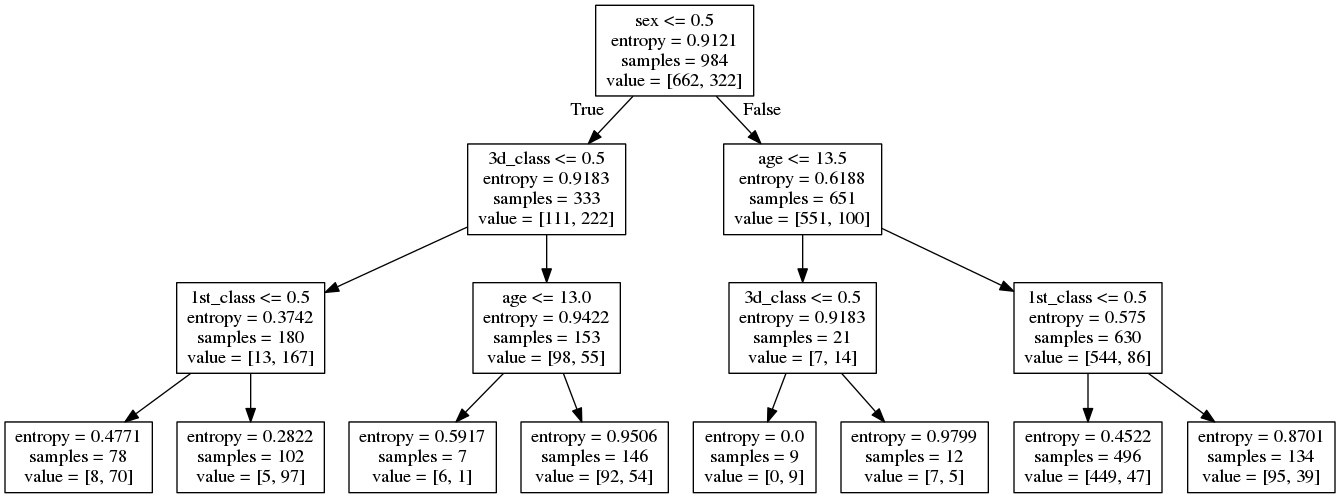

In [47]:
# to create the tree diagram, we need to install some Python libs
# pydoc, http://www.graphviz.org/
# sudo apt-get install graphviz
# pip uninstall pydot
# pip install pydot2
from IPython.core.display import Image
import pydot, StringIO

dot_data = StringIO.StringIO()
tree.export_graphviz(clf, out_file=dot_data, feature_names=['age','sex','1st_class','2nd_class','3d_class'])
graph = pydot.graph_from_dot_data(dot_data.getvalue())
graph.write_png('decision_tree_titanic.png')
Image(filename='decision_tree_titanic.png')

In [48]:
# let implement the desicion tree and evaluate the performance
from sklearn import metrics
def measure_performance(X, y, clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred = clf.predict(X)
    if show_accuracy:
        print "Accuracy:{0:.3f}".format(
            metrics.accuracy_score(y, y_pred)), "\n"
    
    if show_classification_report:
        print "Classification Report:"
        print metrics.classification_report(y, y_pred), "\n"
    
    if show_confusion_matrix:
        print "Confusion matrix:"
        print metrics.confusion_matrix(y, y_pred), "\n"

# run report
measure_performance(X_train, y_train, clf, True, True, True)

Accuracy:0.838 

Classification Report:
             precision    recall  f1-score   support

        0.0       0.82      0.98      0.89       662
        1.0       0.93      0.55      0.69       322

avg / total       0.85      0.84      0.82       984


Confusion matrix:
[[649  13]
 [146 176]] 



In [49]:
# cross validation
# leave-one-out cross-validation
from sklearn.cross_validation import cross_val_score, LeaveOneOut
from scipy.stats import sem

def loo_cv(X_train, y_train, clf):
    loo = LeaveOneOut(X_train[:].shape[0])
    scores = np.zeros(X_train[:].shape[0])
    for train_index, test_index in loo:
        X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
        y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
        clf = clf.fit(X_train_cv, y_train_cv)
        y_pred = clf.predict(X_test_cv)
        scores[test_index] = metrics.accuracy_score(y_test_cv.astype(int), y_pred.astype(int))
    print "Mean score: {0:.3f} (+/- {1:.3f})".format(np.mean(scores), sem(scores))

loo_cv(X_train, y_train, clf)

Mean score: 0.837 (+/- 0.012)


(984, 5)